In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
BASE_DIR = "/content/dataset"


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/non_violence/
  inflating: dataset/non_violence/NON_VIOLENCE (1).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (10).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (100).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (101).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (102).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (103).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (104).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (105).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (106).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (107).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (108).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (109).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (11).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (110).jpg  
  inflating: dataset/non_violence/NON_VIOLENCE (111).jpg  
  inflating: dataset/non_violence/NON_VI

In [11]:
def max_pooling(img, pool_size=2):
    h, w = img.shape
    img = img[:h - h % pool_size, :w - w % pool_size]

    return img.reshape(
        h // pool_size, pool_size,
        w // pool_size, pool_size
    ).max(axis=(1, 3))


In [3]:
def extract_good_features(folder, label):
    X, y = [], []

    if not os.path.exists(folder):
        print("Folder not found:", folder)
        return np.array(X), np.array(y)

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        img = max_pooling(img)
        img = img / 255.0

        X.append(img.flatten())
        y.append(label)

    return np.array(X), np.array(y)


In [4]:
def load_good_split(split):
    X, y = [], []

    f, l = extract_good_features(f"{BASE_DIR}/violence/{split}", 1)
    X.extend(f); y.extend(l)

    f, l = extract_good_features(f"{BASE_DIR}/non_violence/{split}", 0)
    X.extend(f); y.extend(l)

    return np.array(X), np.array(y)


In [12]:
X_train, y_train = load_good_split("train")
X_val, y_val     = load_good_split("val")
X_test, y_test   = load_good_split("test")

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Val class distribution  :", np.bincount(y_val.astype(int)))
print("Test class distribution :", np.bincount(y_test.astype(int)))


Train: (700, 4096) (700,)
Val  : (156, 4096) (156,)
Test : (117, 4096) (117,)
Train class distribution: [390 310]
Val class distribution  : [78 78]
Test class distribution : [20 97]


In [13]:
good_model = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        probability=True
    ))
])


In [14]:
good_model.fit(X_train, y_train)
print("Training done ✅")


Training done ✅


In [15]:
pca_step = good_model.named_steps["pca"]
X_train_pca = pca_step.transform(X_train)

print("Before PCA:", X_train.shape[1])
print("After PCA :", X_train_pca.shape[1])
print("Explained variance ratio sum:", pca_step.explained_variance_ratio_.sum())


Before PCA: 4096
After PCA : 289
Explained variance ratio sum: 0.9501874507294533


In [18]:
y_train_pred = good_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("TRAIN ACCURACY:", train_acc)
print(classification_report(y_train, y_train_pred, target_names=["non-violence", "violence"]))


TRAIN ACCURACY: 0.8542857142857143
              precision    recall  f1-score   support

non-violence       0.91      0.82      0.86       390
    violence       0.80      0.90      0.84       310

    accuracy                           0.85       700
   macro avg       0.85      0.86      0.85       700
weighted avg       0.86      0.85      0.85       700



In [17]:
y_val_pred = good_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("VALIDATION ACCURACY:", val_acc)
print(classification_report(y_val, y_val_pred, target_names=["non-violence", "violence"]))


VALIDATION ACCURACY: 0.6410256410256411
              precision    recall  f1-score   support

non-violence       0.62      0.73      0.67        78
    violence       0.67      0.55      0.61        78

    accuracy                           0.64       156
   macro avg       0.65      0.64      0.64       156
weighted avg       0.65      0.64      0.64       156



In [19]:
y_test_pred = good_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("TEST ACCURACY:", test_acc)
print(classification_report(y_test, y_test_pred, target_names=["non-violence", "violence"]))


TEST ACCURACY: 0.7008547008547008
              precision    recall  f1-score   support

non-violence       0.33      0.75      0.46        20
    violence       0.93      0.69      0.79        97

    accuracy                           0.70       117
   macro avg       0.63      0.72      0.63       117
weighted avg       0.83      0.70      0.74       117



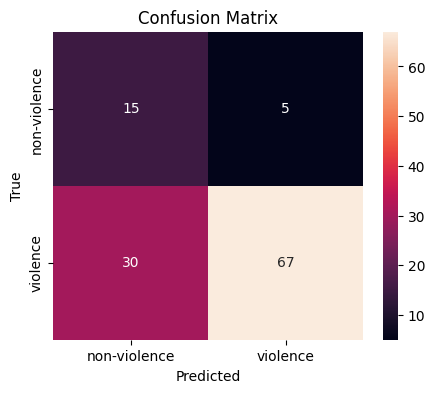

In [20]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["non-violence", "violence"],
            yticklabels=["non-violence", "violence"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
joblib.dump(good_model, "violence_pca_svm_pipeline.joblib")
print("Saved  as one file: violence_pca_svm_pipeline.joblib")


Saved  as one file: violence_pca_svm_pipeline.joblib
